In [135]:
import tensorflow as tf
import numpy as np # for numerical operations and linear algebra
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from typing import Tuple
from tf

image_dir = "C:/Users/austi/Downloads/datasetImages_warp256/"
label_csv_path = "C:/Users/austi/Downloads/"


batch_size = 32
epochs = 50




In [6]:
toPILImage = lambda x: tf.keras.preprocessing.image.array_to_img(x)

In [9]:
    attributes = [
        "balancing_elements",
        "color_harmony",
        "content",
        "depth_of_field",
        "light",
        "motion_blur",
        "object",
        "repetition",
        "rule_of_thirds",
        "symmetry",
        "vivid_color",
        "score"
    ]

In [89]:
class AADB():

    attributes = [
        "balancing_elements",
        "color_harmony",
        "content",
        "depth_of_field",
        "light",
        "motion_blur",
        "object",
        "repetition",
        "rule_of_thirds",
        "symmetry",
        "vivid_color",
        "score"
    ]


    
    def __init__(self, image_dir, label_csv_path, test=False):
        self.label_csv_path = label_csv_path
        self.image_dir = image_dir
        self.test=test
        #self.transform = T.Compose([T.Resize(size=(256, 256)), T.ToTensor()])
        self.transform = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        self.files, self.labels = self.load_data(self.image_dir, self.label_csv_path, self.test)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image = Image.open(self.files[index]).convert("RGB")
#         print("Image Name: {}".format(self.files[index].split("/")[-1]))
        image = image.resize((256, 256))
        # convert to tensor
        image = tf.convert_to_tensor(np.array(image))
        print(image.shape)
        #label = torch.from_numpy(self.labels[index])
        label = self.labels[index]
        return image, label

    def load_data(self, image_dir, csv_path, test=False):
        csv_file = csv_path + 'Dataset.csv' if not test else csv_path + 'Dataset_test.csv'
        label_csv = pd.read_csv(csv_file, delimiter=",")
        files = [os.path.join(image_dir, f) for f in label_csv['ImageFile']]
#         labels = np.asarray([label.values for index, label in label_csv.drop(['ImageFile'], axis=1).iterrows()])
        labels = []
        for index, label in label_csv.drop(['ImageFile'], axis=1).iterrows():  # this is for moving score to the last value
            label = list(label.values)
            label.append(label.pop(9))
            labels.append(label)
            
        labels = np.asarray(labels)
        return files, labels

In [78]:
aadb = AADB(image_dir, label_csv_path)

In [132]:
def show_example(img: tf.Tensor, label):
    print(label)
   #plt.imshow(img.permute(1, 2, 0))
    plt.imshow(img)
    plt.show()

In [105]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(tf.keras.preprocessing.image.array_to_img(images[0]))
        break

(256, 256, 3)
[-0.2  0.2 -0.2 -0.4  0.   0.  -0.4  0.  -0.2  0.   0.3  0. ]
(256, 256, 3)


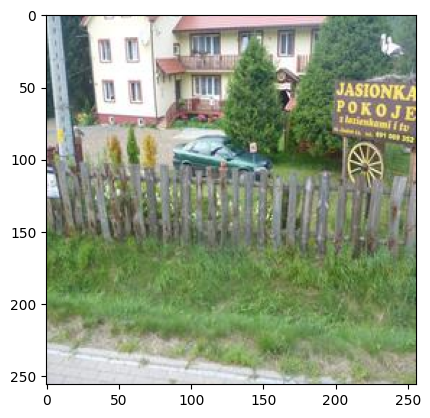

8958

In [131]:
show_example(*aadb[0])
len(aadb)

In [133]:
val_size = 500
train_size = len(aadb) - val_size

#train_ds, val_ds = random_split(aadb, [train_size, val_size])
train_ds, val_ds = tf.data.Dataset.from_tensor_slices(aadb.files[:train_size]), tf.data.Dataset.from_tensor_slices(aadb.files[train_size:])
len(train_ds), len(val_ds)

(8458, 500)

In [134]:
train_dl = train_ds.batch(batch_size=batch_size, drop_remainder=True, ).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dl = val_ds.batch(batch_size=batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

for i in train_dl.take(2):
    print(i)
    break


tf.Tensor(
[b'C:/Users/austi/Downloads/datasetImages_warp256/farm1_333_19438364933_087c8abc60_b.jpg'
 b'C:/Users/austi/Downloads/datasetImages_warp256/farm1_452_19898743300_201156d984_b.jpg'
 b'C:/Users/austi/Downloads/datasetImages_warp256/farm1_281_20247100976_c8141d3653_b.jpg'
 b'C:/Users/austi/Downloads/datasetImages_warp256/farm1_448_19709457333_be4c6bb5eb_b.jpg'
 b'C:/Users/austi/Downloads/datasetImages_warp256/farm1_393_20179744375_c119001350_b.jpg'
 b'C:/Users/austi/Downloads/datasetImages_warp256/farm1_275_19803259169_c8b4c4c425_b.jpg'
 b'C:/Users/austi/Downloads/datasetImages_warp256/farm1_322_19703546844_24870f2139_b.jpg'
 b'C:/Users/austi/Downloads/datasetImages_warp256/farm1_465_20205184465_6258b8184e_b.jpg'
 b'C:/Users/austi/Downloads/datasetImages_warp256/farm1_365_20165810645_4f027d6d58_b.jpg'
 b'C:/Users/austi/Downloads/datasetImages_warp256/farm4_3736_19541030833_e68fa6b476_b.jpg'
 b'C:/Users/austi/Downloads/datasetImages_warp256/farm1_266_19542969634_b6e00123a9_b.jpg

In [136]:
class RankLoss(tf.Module):

    def marginal_ranking_loss(self, y_pred, y_true, target, margin):
        return max(0, margin - target * (y_pred[0] - y_pred[1]))

    def __init__(self, margin):
        super().__init__()
        self.margin = margin

    def forward(self,
        y_pred: Tuple[tf.Tensor, tf.Tensor],
        y_true: Tuple[tf.Tensor, tf.Tensor]) -> tf.Tensor:

        device, dtype = y_pred[0].device, y_pred[0].dtype

        target = tf.ones_like(y_true[0]).to(device).to(dtype)

        # Set indices where y_true1 < y_true2 to -1
        target[y_true[0] < y_true[1]] = -1.0

        return tf.math.reduce_mean(
            tf.math.maximum(
                0.0,
                self.margin - target * (y_pred[0] - y_pred[1])
            )
        )




In [137]:
class RegRankLoss(tf.Module):

    def __init__(self, margin: float):
        super().__init__()
        self.reg_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
        self.rank_loss = RankLoss(margin)

    def forward(self,
        y_pred: Tuple[tf.Tensor, tf.Tensor],
        y_true: Tuple[tf.Tensor, tf.Tensor]) -> Tuple[tf.Tensor, tf.Tensor]:
        
        loss_reg = (
            self.reg_loss(y_pred[0], y_true[0]) +
            self.reg_loss(y_pred[1], y_true[1])
        ) / 2.0

        loss_rank = self.rank_loss(y_pred, y_true)
        loss = loss_reg + loss_rank
        return loss, loss_reg, loss_rank

In [ ]:
class Backbone(tf.Module):

    def __init__(self, backbone, pretrained):
        super().__init__()
        #resnet = getattr(torchvision.models, backbone)(pretrained=pretrained)
        resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
        #self.num_features = resnet.fc.in_features
        self.num_features = resnet.input_shape
        #self.model = tf.Sequential(*list(resnet.children())[:-1])
        self.model = tf.keras.models.Sequential(*list(resnet.layers)[:-1])

    def forward(self, x: tf.Tensor) -> tf.Tensor:
        return self.model(x).squeeze()